# Module 2: Explore and Visualize Data

In this module we will use seaborn, a Python data visualization library that provides a high-level interface for building visuals on dataframes and arrays. You can learn more about seaborn [here](https://seaborn.pydata.org/).

Please add the lakehouse you created earlier as the default lakehouse in this notebook. 

#### Read delta table from lakehouse and create a pandas dataframe on a random sample of the data
Note: For the purpose of minimizing runtime in this tutorial, We are using a 1/1000 sample to explore and visualize ingested data

In [6]:
data = spark.read.format("delta").load("Tables/nyctaxi_raw")
SEED = 1234
sampled_df = data.sample(True, 0.001, seed=SEED).toPandas()

display(sampled_df)

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 5d3de05e-8c68-42b0-8119-6748caccb259)

##### Import visualization libraries and set figure config

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 5, Finished, Available, Finished)

##### Visual 1: Distribution of trip duration(minutes) on linear and logarithmic scale

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 14, Finished, Available, Finished)

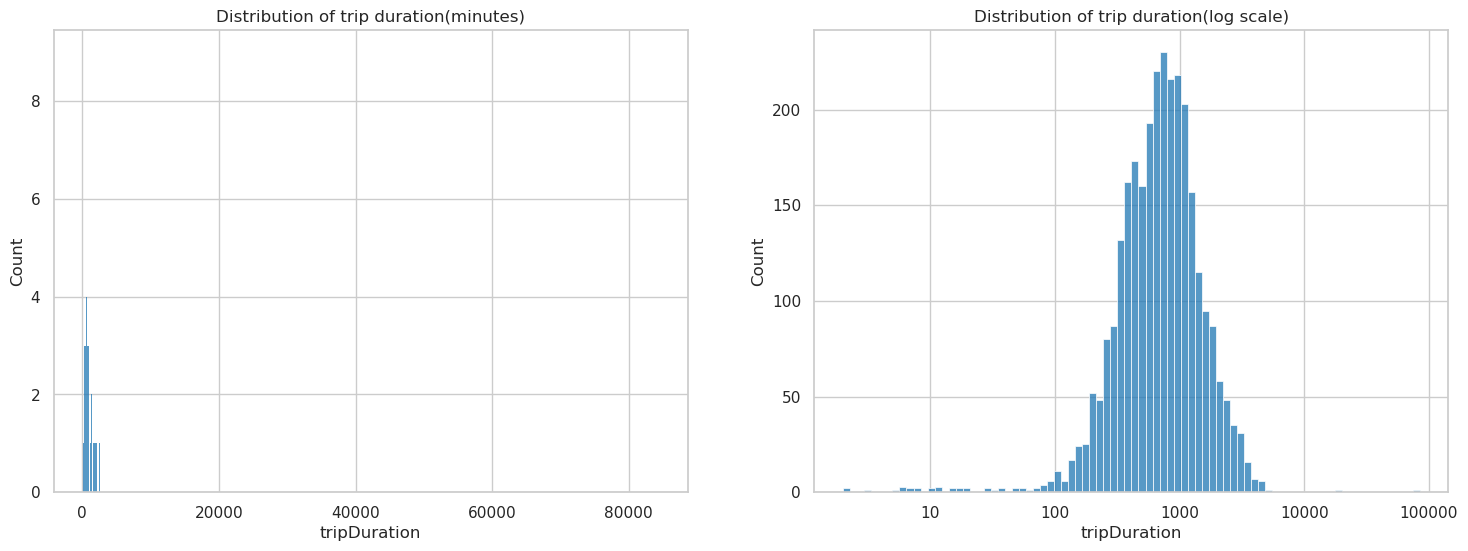

In [12]:
## Compute trip duration(in minutes) on the sample using pandas
sampled_df['tripDuration'] = (sampled_df['tpep_dropoff_datetime'] - sampled_df['tpep_pickup_datetime']).astype('timedelta64[s]').astype('int')
sampled_df = sampled_df[sampled_df["tripDuration"] > 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(ax=axes[0],data=sampled_df,
            x="tripDuration",
            stat="count",
            discrete=True).set(title='Distribution of trip duration(minutes)')
sns.histplot(ax=axes[1],data=sampled_df,
            x="tripDuration",
            stat="count", 
            log_scale= True).set(title='Distribution of trip duration(log scale)')
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())

#### Visual 2: Lets create bins to visualize duration of trips better

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 15, Finished, Available, Finished)

Text(0, 0.5, 'Frequency')

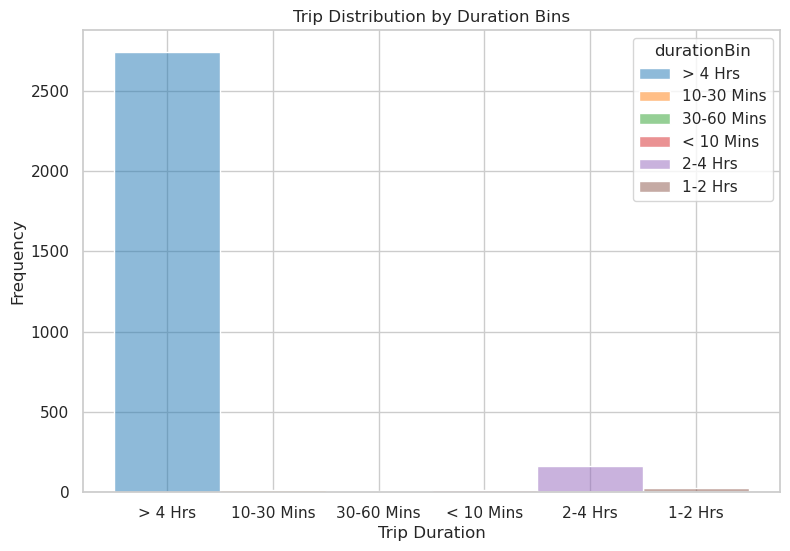

In [13]:
## Create bins for tripDuration column
sampled_df.loc[sampled_df['tripDuration'].between(0, 10, 'both'), 'durationBin'] = '< 10 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(10, 30, 'both'), 'durationBin'] = '10-30 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(30, 60, 'both'), 'durationBin'] = '30-60 Mins'
sampled_df.loc[sampled_df['tripDuration'].between(60, 120, 'right'), 'durationBin'] = '1-2 Hrs'
sampled_df.loc[sampled_df['tripDuration'].between(120, 240, 'right'), 'durationBin'] = '2-4 Hrs'
sampled_df.loc[sampled_df['tripDuration'] > 240, 'durationBin'] = '> 4 Hrs'

# Plot histogram using the binned column
sns.histplot(data=sampled_df, x="durationBin", stat="count", discrete=True, hue = "durationBin")
plt.title("Trip Distribution by Duration Bins")
plt.xlabel('Trip Duration')
plt.ylabel('Frequency')

#### Visual 3: Visualize the distribution of tripDuration and tripDistance and classify by passengerCount

In [27]:
# Get the column names and their data types
column_types = sampled_df.dtypes
print(column_types)


StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 29, Finished, Available, Finished)

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
tripDuration                      int64
durationBin                      object
dtype: object


StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 30, Finished, Available, Finished)

<Axes: xlabel='trip_distance', ylabel='tripDuration'>

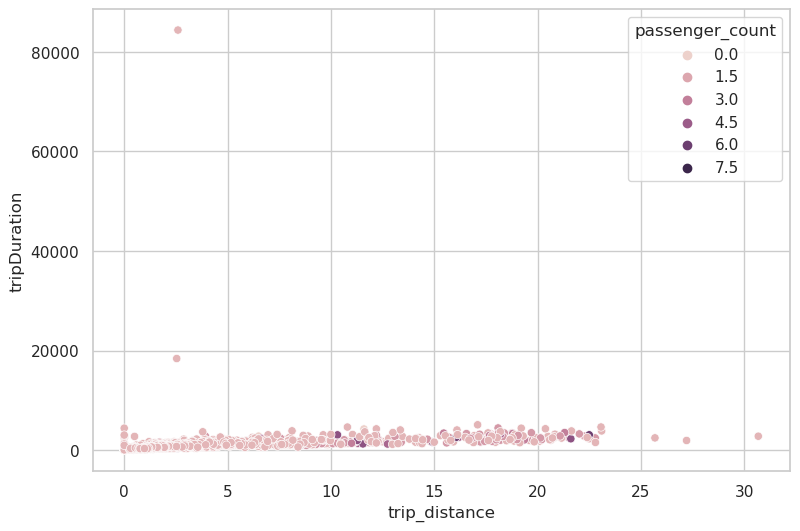

In [28]:
sns.scatterplot(data=sampled_df, x="trip_distance", y="tripDuration", hue="passenger_count")

#### Visual 4: Visualize distribution of passengercount per trip

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 32, Finished, Available, Finished)

Text(0, 0.5, 'Number of trips')

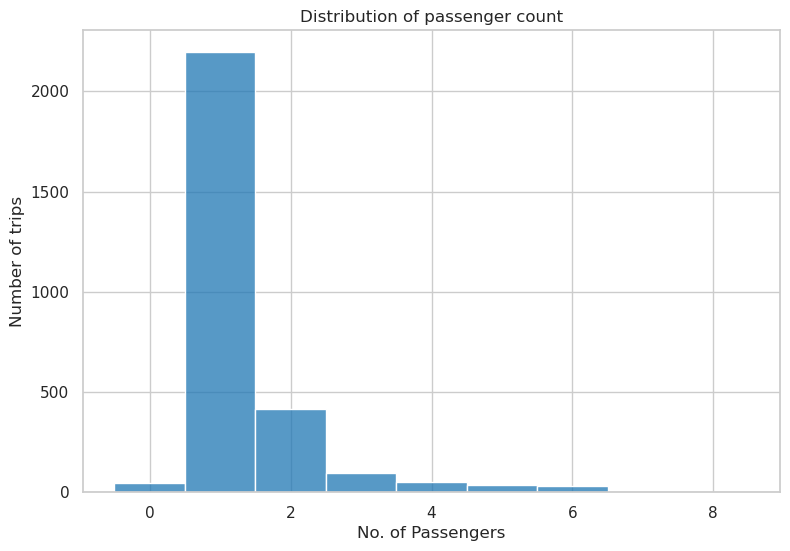

In [30]:
sns.histplot(data=sampled_df, x="passenger_count", stat="count", discrete=True)
plt.title("Distribution of passenger count")
plt.xlabel('No. of Passengers')
plt.ylabel('Number of trips')

#### Visual 5:  Create boxplots to visualize the distribution of tripDuration by passenger count
A boxplot is a useful tool to understand the variability, symmetry, and outliers of the data.
- In first figure lets visualize tripDuration without removing any outliers
- In the second figure we are removing trips with duration greater than ~3 hours and zero passengers.

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 35, Finished, Available, Finished)

[Text(0.5, 1.0, 'Distribution of Trip duration by passengerCount (outliers removed)')]

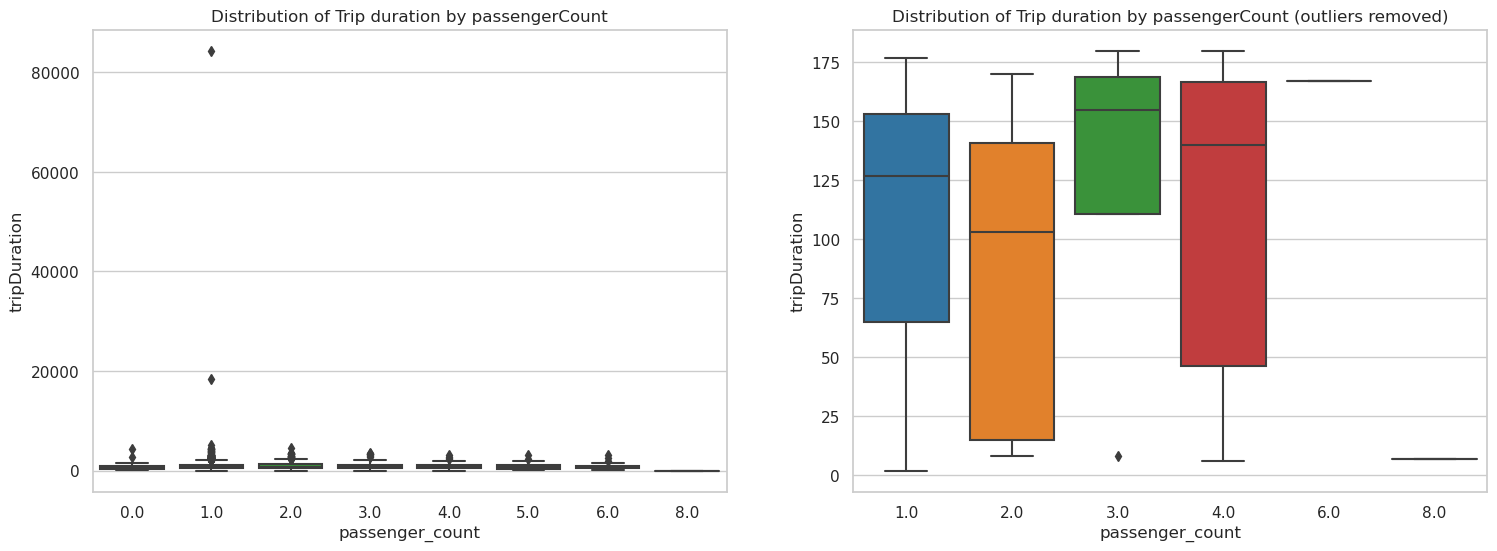

In [33]:
# The threshold was calculated by evaluating mean trip duration (~15 minutes) + 3 standard deviations (58 minutes), i.e. roughly 3 hours.
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.boxplot(ax=axes[0], data=sampled_df, x="passenger_count", y="tripDuration").set(title='Distribution of Trip duration by passengerCount')
sampleddf_clean = sampled_df[(sampled_df["passenger_count"] > 0) & (sampled_df["tripDuration"] <= 180)]
sns.boxplot(ax=axes[1], data=sampleddf_clean, x="passenger_count", y="tripDuration").set(title='Distribution of Trip duration by passengerCount (outliers removed)')

#### Visual 6: Analyze the relationship of tripDuration and fareAmount classified by paymentType and VendorId using a scatterplot/subplots

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 37, Finished, Available, Finished)

Text(0.5, 1.0, 'Distribution of tripDuration by fare_amount')

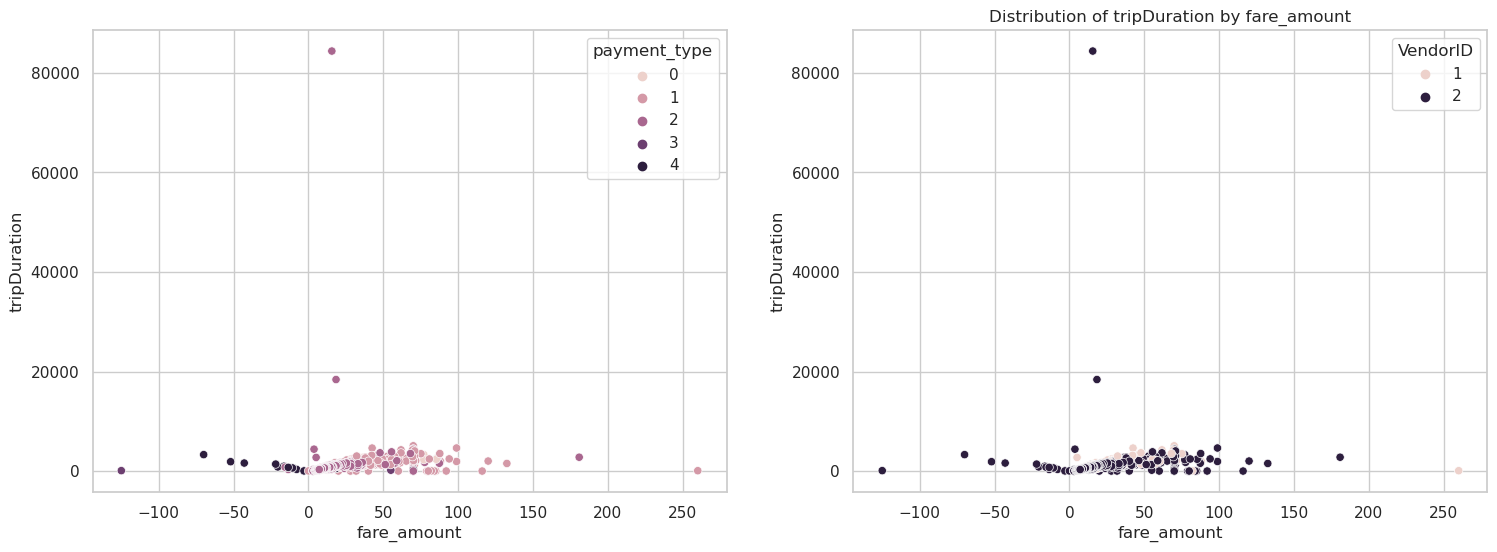

In [35]:
f, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.scatterplot(ax =axes[0], data=sampled_df, x="fare_amount", y="tripDuration",  hue="payment_type")
sns.scatterplot(ax =axes[1],data=sampled_df, x="fare_amount", y="tripDuration",  hue="VendorID")
plt.title("Distribution of tripDuration by fare_amount")

#### Visual 7: Analyze the frequency of the taxi trips by hour of the day

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 40, Finished, Available, Finished)

Text(0, 0.5, 'Count of trips')

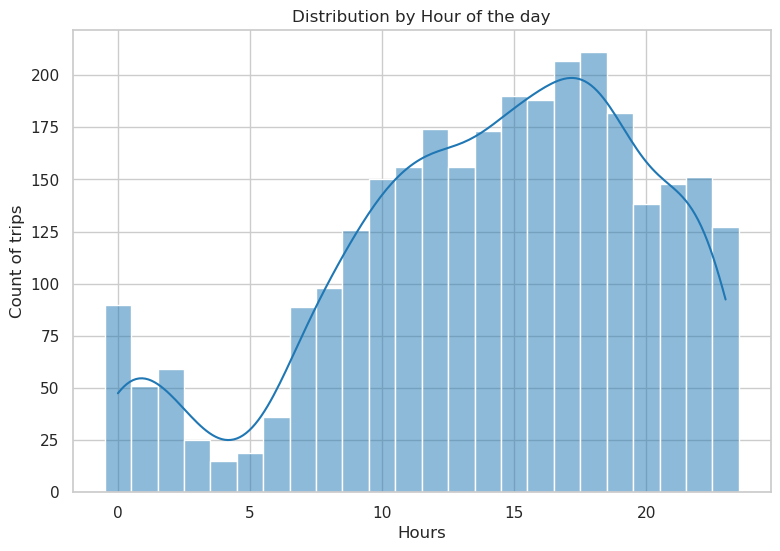

In [38]:
sampled_df['hour'] = sampled_df['tpep_pickup_datetime'].dt.hour
sampled_df['dayofweek'] = sampled_df['tpep_dropoff_datetime'].dt.dayofweek
sampled_df['dayname'] = sampled_df['tpep_dropoff_datetime'].dt.day_name()
sns.histplot(data=sampled_df, x="hour", stat="count", discrete=True, kde=True)
plt.title("Distribution by Hour of the day")
plt.xlabel('Hours')
plt.ylabel('Count of trips')

#### Visual 8: Analyze average taxi trip duration by hour and day of the week using a heatmap

In [42]:
pv_df = sampled_df[sampled_df["tripDuration"]<180]\
        .groupby(["hour","dayname"]).mean("tripDuration")\
        .reset_index().pivot("hour", "dayname", "tripDuration")
sns.heatmap(pv_df,annot=True,fmt='.2f', cmap="Blues").set(xlabel=None)

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 44, Finished, Available, Finished)

TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

#### Visual 9: Create a Correlation plot 
A correlation plot is a useful tool for exploring the relationships among numerical variables in a dataset. It displays the data points for each pair of variables as a scatterplot, and also calculates the correlation coefficient for each pair. The correlation coefficient indicates how strongly and in what direction the variables are related. A positive correlation means that the variables tend to increase or decrease together, while a negative correlation means that they tend to move in opposite directions.

StatementMeta(, 03bedc65-b413-4940-ab2d-90fd3e2a1d33, 46, Finished, Available, Finished)

<Axes: >

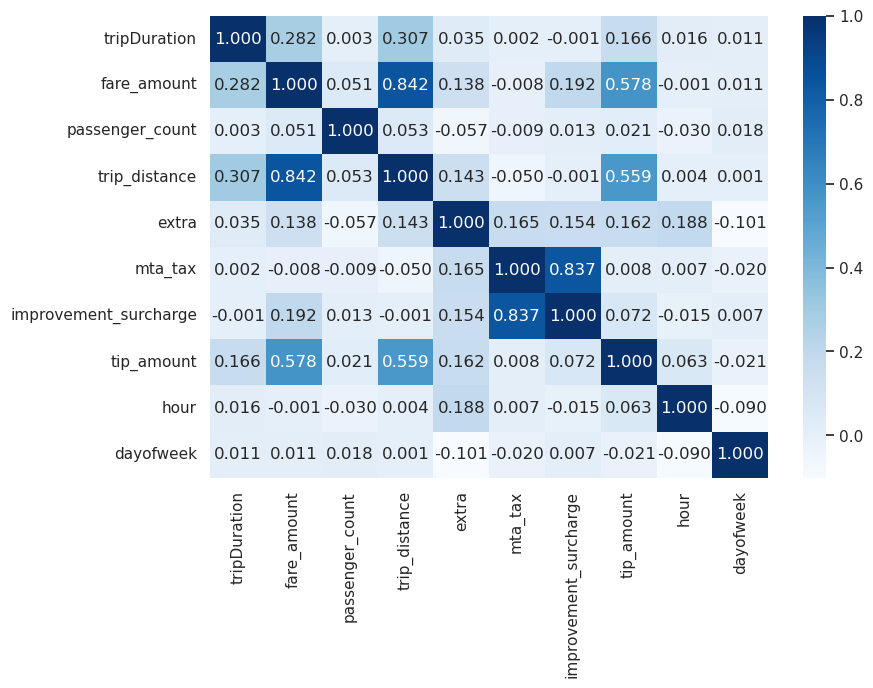

In [44]:
cols_to_corr = ['tripDuration','fare_amount', 'passenger_count', 'trip_distance', 'extra', 'mta_tax',
       'improvement_surcharge', 'tip_amount', 'hour',"dayofweek"]
sns.heatmap(data = sampled_df[cols_to_corr].corr(),annot=True,fmt='.3f', cmap="Blues")

#### Summary of observations from data exploration:

Are these correct for your dataset?

1) Some trips in the sample have passenger count of 0 but most trips have a passenger count between 1-6.
2) tripDuration column has outliers with a comparatively small number of trips having trip duration of greater than 3 hours.
3) The outliers for TripDuration are specifically for vendorId 2.
4) Some trips have zero tripdistance and hence can be treated as cancelled and filtered out.
5) A small number of trips have no passengers (0) and hence can be filtered out.
6) fareAmount column contains negative outliers which can be removed from training.
6) The number of trips start rising around 16:00 hours and peaks between 18:00 - 19:00 hours.